# Wide Quantum Circuit Learning

In [1]:
import pennylane as qml
from pennylane import numpy as np
import pennylane.optimize

In [2]:
import os
import time
import random
import pickle
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torchsummary import summary

In [3]:
from tqdm import tqdm
from MNISTData import MNISTData
from AutoEncoder import AutoEncoder

In [4]:
ENCODING_SIZE = 10
NUM_QUBITS =4
NUM_CLASSES= 10
# NUM_LAYERS specifies how many times the circuit is run over the qubit wires.
# Should increase runtime by a factor of NUM_LAYERS.
NUM_LAYERS = 10

In [19]:
dev = qml.device("forest.qvm", device="{}q-pyqvm".format(NUM_QUBITS), shots=1000)
device = torch.device('cpu') # CUDA broke for some reason

In [6]:
from pennylane.ops import RX, RY, CNOT

# x will be a length ENCODING_SIZE vector that represents
# the encoding of a MNIST image
# thetas is of size 2 * NUM_QUBITS
@qml.qnode(dev)
def circuit(x, thetas):
    for i in range(ENCODING_SIZE):
        RX(x[i], wires=i)
    for j in range(NUM_LAYERS):
        for i in range(NUM_QUBITS - 1):
            CNOT(wires=[i, i+1])
        for i in range(NUM_QUBITS):
            RX(thetas[j][i], wires=i)
        for i in range(NUM_QUBITS, 2 * NUM_QUBITS):
            RY(thetas[j][i], wires=(i - NUM_QUBITS))
    return tuple(qml.expval.PauliZ(wires=i) for i in range(NUM_QUBITS))


#params: x - input x
#        mask - mapping from range(ENCODING SIZE) to range(4)
#        thetas - learned parameters
#NOTE: Written for NUM_QUBITS = 4
@qml.qnode(dev)
def circuit_tighten(x, mask, thetas):
    for i in range(ENCODING_SIZE):
            if i // NUM_QUBITS % 2 == 0: 
                RX(x[i], wires=i//NUM_QUBITS)
            else:
                RY(x[i], wires=i//NUM_QUBITS)
    for j in range(NUM_LAYERS):
        CNOT(wires=[0, 1])
        CNOT(wires=[1, 3])
        CNOT(wires=[0, 2])
        for i in range(NUM_QUBITS):
            RX(thetas[j][i], wires=i)
        for i in range(NUM_QUBITS, 2 * NUM_QUBITS):
            RY(thetas[j][i], wires=(i - NUM_QUBITS))
    return [qml.expval.PauliZ(wires=i) for i in range(NUM_QUBITS)]

def get_mask():
    sub_masks = []
    for i in range(ENCODING_SIZE//NUM_QUBITS + 1):
        sub_masks.append(np.random.permutation(NUM_QUBITS))
    res = np.concatenate(sub_masks).flatten()
    return res.tolist()

In [7]:
# example input
MASK = get_mask()
print(np.mean(circuit_tighten([np.pi/5]*(ENCODING_SIZE), MASK, [[np.pi]*(2 * NUM_QUBITS)]*NUM_LAYERS)))

-0.514


In [8]:
# NOTE: EDITED COST FUNCTION to use bias, and to prevent bias from gaming
#       the cost function.
def cost(X, actual_labels, thetas, bias):
    b = X.shape[0]
    yhats = []
    for i in range(b):
        scores = []
        for j in range(NUM_CLASSES):
            scores.append(np.mean(circuit_tighten(X[i], MASK, thetas[j]) + bias[j]))
        yhats.append(scores)
    st = np.stack(yhats)
    actual_class_vals = st[range(b), actual_labels]
    shifted = st - np.max(st, axis=1)[:, np.newaxis]
    the_sum = np.log(np.sum(np.exp(shifted), axis=1)) 
    # Return loss + regularization term on bias
    return np.mean(-actual_class_vals + the_sum + np.max(st, axis=1))

At this point, we have to get our (encoded) images so that we may actually start training

In [9]:
data = MNISTData(batch_size=16)
train_loader = data.get_train_loader()
test_loader = data.get_test_loader()

In [10]:
load_from_stem = "./autoencoder_models/1558731906/"
load_model_from = os.path.join(load_from_stem, "ae.pt")
load_layers_from = os.path.join(load_from_stem, "layer_sizes.pkl")

In [24]:
with open(load_layers_from, 'rb') as f:
    layer_sizes = pickle.load(f)
layer_sizes = layer_sizes[1:]
ae = AutoEncoder(layer_sizes)
ae.load_state_dict(torch.load(load_model_from))
encoder = ae.encoder
#encoder.to(torch.device('cpu'))
for child in encoder.children():
    for param in child.parameters():
        param.to(device)
        param.requires_grad = False

In [26]:
#summary(encoder, input_size=(28 * 28,))

In [27]:
thetas = 1/ENCODING_SIZE*np.random.randn(2 * NUM_QUBITS*NUM_LAYERS*NUM_CLASSES)
bias = np.zeros(NUM_CLASSES)
thetas = thetas.reshape(NUM_CLASSES, NUM_LAYERS, 2*NUM_QUBITS)
init_thetas = thetas.copy()
init_bias = bias.copy()
print(thetas)
print(thetas.dtype)
print(bias)

[[[-6.93272692e-02  1.45557304e-01  1.96258536e-02  4.92572044e-02
    2.86002524e-02  2.67874539e-03 -1.36497609e-01 -1.29693774e-01]
  [ 5.28170545e-03  1.73152368e-02  1.20033652e-01 -4.09673340e-02
    7.36273027e-02  1.81620921e-01  1.00297862e-01  1.15013003e-01]
  [-1.25851371e-01 -3.65946593e-02 -6.20383430e-02 -4.86575796e-02
    1.56828454e-01  6.22889331e-03 -1.07883428e-01  1.29360868e-01]
  [ 1.82661661e-01 -5.53966526e-02 -1.06042793e-01 -2.86474858e-02
   -9.27377093e-02  8.08325151e-02 -6.56148730e-02 -5.74184845e-02]
  [-9.03848553e-02  2.33398880e-03 -3.35526073e-02 -6.07871751e-02
   -4.25976067e-02 -4.99933989e-02  5.14387773e-02 -1.98567480e-02]
  [ 6.89820331e-03 -8.32829595e-02 -7.02132117e-02 -5.34753070e-02
    3.48335981e-02 -1.44093779e-01  8.70005052e-02 -1.42693613e-01]
  [-7.17621416e-02 -9.29931086e-02  2.24445971e-01  6.66973905e-02
    3.65534077e-02 -8.31356583e-02  7.98029006e-02  2.92216589e-02]
  [ 4.64260847e-02 -1.86904130e-01  8.45702613e-02  1.1

   -1.47135550e-01  6.90650320e-02  7.37039235e-02  9.34392887e-03]]]
float64
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [28]:
# this is the transformation that you need to do in order
# to pass it to the encoder. view is (1, -1) since the first number
# is the number of channels, which in our case is 1
enums = enumerate(train_loader, 0)
i, data = next(enums)
inputs, labels = data
print(inputs.size())
print(len(labels))
print(encoder(inputs[0].view(1, -1)))
print(encoder(inputs[0].view(1, -1)).size())
print(circuit_tighten(inputs[0].view(1, -1).numpy(), MASK, thetas[0]))

torch.Size([16, 1, 28, 28])
16
tensor([[30.2819, 26.8369,  0.0000,  0.0000,  5.9683,  9.9852, 24.6056,  7.1161,
         32.1565,  0.0000]])
torch.Size([1, 10])
[ 0.174 -0.206  0.198 -0.266]


In [29]:
# Using normal qml.grad
X = encoder(inputs.view(len(labels), -1))
print(X.size())
print(labels.size())
print(thetas.shape)
start = time.time()
dcost = qml.grad(cost, argnum=[2, 3])
theta_grad, bias_grad = dcost(X.numpy(), labels.numpy(), thetas, bias) 
print(time.time() - start)

torch.Size([16, 10])
torch.Size([16])
(10, 10, 8)
309.74271988868713


In [30]:
def accuracy(thetas, bias, number_batches=2):
    correct = 0
    total = 0
    for i, data in enumerate(test_loader, 0):
        if i == number_batches:
            break
        inputs, labels = data
        inputs = encoder(inputs.view(len(labels), -1)).numpy()
        predicted = []
        for image in inputs:
            scores = []
            for i in range(NUM_CLASSES):
                scores.append(np.mean(circuit_tighten(image, MASK, thetas[i]) + bias[i]))
            predicted.append(np.argmax(scores))
        correct += (np.asarray(predicted) == labels.numpy()).sum()
        total += len(predicted)
        print(predicted)
    return(correct / total)
# have done no training, so should be around 10%
accuracy(thetas, bias)

[3, 7, 7, 4, 7, 0, 2, 9, 8, 3, 7, 7, 4, 4, 3, 6]
[2, 7, 5, 7, 7, 7, 7, 7, 3, 4, 4, 5, 5, 5, 6, 9]


0.0625

In [33]:
accuracies = []
losses = []

In [32]:
# Overfit like crazy on the first 16 examples
# Five minutes a batch
overfit = []
for i, data in enumerate(train_loader, 0):
    overfit.append((i, data))
    if i == 0:
        break

In [78]:
etas = [1e-2]
start = time.time()
for eta in etas:
    for epoch in range(4):
        for i, data in overfit:
            inputs, labels = data
            X = encoder(inputs.view(len(labels), -1))
            dcost = qml.grad(cost, argnum=[2,3])
            theta_grad, bias_grad = dcost(X.numpy(), labels.numpy(), thetas, bias)
            loss = cost(X.numpy(), labels.numpy(), thetas, bias)
            losses.append(loss)
            thetas -= eta * theta_grad
            bias -= eta * bias_grad
            acc = accuracy(thetas, bias)
            accuracies.append(acc)
            print("%d batches took %f seconds and has accuracy %f, with train loss %f" % (i + 1, time.time() - start, acc, loss))
            if i == 1:
                break

[3, 8, 3, 0, 0, 3, 2, 3, 0, 2, 0, 0, 3, 3, 0, 5]
[2, 5, 5, 8, 0, 3, 5, 0, 3, 5, 2, 5, 5, 5, 0, 3]
1 batches took 331.432343 seconds and has accuracy 0.093750, with train loss 1.832432
[3, 8, 3, 0, 0, 3, 8, 3, 0, 2, 0, 0, 3, 8, 0, 5]
[2, 5, 5, 8, 0, 3, 5, 0, 3, 5, 2, 5, 5, 5, 0, 3]
1 batches took 665.513576 seconds and has accuracy 0.093750, with train loss 1.830845
[3, 8, 3, 0, 0, 3, 2, 3, 0, 2, 0, 0, 3, 8, 0, 5]
[2, 5, 5, 8, 0, 3, 5, 0, 3, 5, 2, 5, 5, 5, 0, 3]
1 batches took 996.357459 seconds and has accuracy 0.093750, with train loss 1.828978
[3, 8, 3, 0, 0, 3, 8, 3, 0, 2, 0, 0, 3, 8, 0, 5]
[2, 5, 5, 8, 0, 3, 5, 0, 3, 5, 2, 5, 5, 5, 0, 3]
1 batches took 1329.855259 seconds and has accuracy 0.093750, with train loss 1.824682


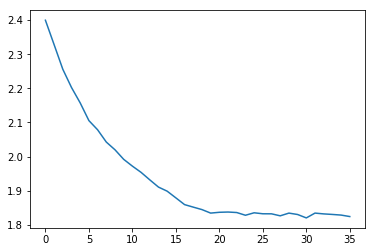

[ 0.26158293 -0.3570366   0.21397489  0.26793371  0.17676492  0.17963767
 -0.36263504 -0.25967539  0.14492601 -0.2654731 ]
3.037363042400416


In [79]:
plt.plot(losses)
plt.show()
print(bias)
diff_thetas = thetas - init_thetas
print(np.sqrt(np.sum(diff_thetas*diff_thetas)))

In [83]:
# Peek at train accuracy:
for i, data in overfit:
    inputs, labels = data
    inputs = encoder(inputs.view(len(labels), -1)).numpy()
    predicted = []
    correct = 0
    total = 0
    for image in inputs:
        scores = []
        for i in range(NUM_CLASSES):
            scores.append(np.mean(circuit_tighten(image, MASK, thetas[i]) + bias[i]))
        predicted.append(np.argmax(scores))
    correct += (np.asarray(predicted) == labels.numpy()).sum()
    total += len(predicted)
    print(labels)
    print(predicted)
    print(correct/total)
over_fit_thetas = thetas.copy()
over_fit_bias = bias.copy()
over_fit_losses = losses.copy()

tensor([2, 3, 8, 3, 5, 8, 2, 9, 5, 4, 1, 4, 7, 0, 0, 6])
[2, 3, 5, 8, 5, 8, 2, 5, 5, 4, 1, 4, 3, 0, 3, 3]
0.625


In [84]:
#Time for the real deal.
#Gonna start with the overfit weights cause screw it
etas = [1, 3e-1, 1e-1]
start = time.time()
accuracies = []
losses = []
for epoch in range(1):
    for eta in etas:
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data
            X = encoder(inputs.view(len(labels), -1))
            dcost = qml.grad(cost, argnum=[2,3])
            theta_grad, bias_grad = dcost(X.numpy(), labels.numpy(), thetas, bias)
            loss = cost(X.numpy(), labels.numpy(), thetas, bias)
            losses.append(loss)
            thetas -= eta * theta_grad
            bias -= eta * bias_grad
            acc = accuracy(thetas, bias)
            accuracies.append(acc)
            print("%d batches took %f seconds and has accuracy %f, with train loss %f" % (i + 1, time.time() - start, acc, loss))
            if i == 12:
                break

tensor([2, 3, 8, 3, 5, 8, 2, 9, 5, 4, 1, 4, 7, 0, 0, 6])
[3, 8, 3, 0, 0, 3, 8, 3, 0, 7, 0, 0, 3, 3, 0, 5]
[8, 5, 5, 8, 0, 3, 5, 0, 3, 5, 5, 5, 5, 5, 0, 3]
1 batches took 333.210537 seconds and has accuracy 0.093750, with train loss 2.238850
tensor([0, 7, 0, 7, 3, 4, 0, 1, 1, 3, 5, 7, 5, 7, 5, 8])
[7, 8, 3, 0, 0, 3, 2, 3, 0, 7, 0, 0, 0, 7, 0, 5]
[2, 5, 5, 5, 0, 3, 5, 0, 7, 5, 5, 5, 0, 5, 0, 0]
2 batches took 671.998153 seconds and has accuracy 0.156250, with train loss 2.514424
tensor([5, 6, 2, 1, 7, 7, 0, 0, 0, 4, 6, 7, 6, 6, 2, 1])
[7, 8, 3, 0, 0, 3, 2, 3, 0, 2, 0, 0, 3, 7, 0, 5]
[2, 5, 5, 5, 0, 3, 5, 0, 7, 5, 5, 5, 5, 5, 0, 0]
3 batches took 992.200486 seconds and has accuracy 0.125000, with train loss 2.495987
tensor([3, 2, 9, 1, 9, 9, 7, 8, 1, 3, 4, 5, 5, 2, 9, 2])
[7, 8, 3, 0, 0, 3, 2, 3, 0, 7, 0, 0, 7, 7, 7, 5]
[2, 5, 5, 8, 0, 3, 5, 0, 7, 5, 5, 5, 5, 5, 0, 7]
4 batches took 1338.977725 seconds and has accuracy 0.125000, with train loss 2.391678
tensor([4, 0, 9, 2, 8, 1, 4, 7, 6, 

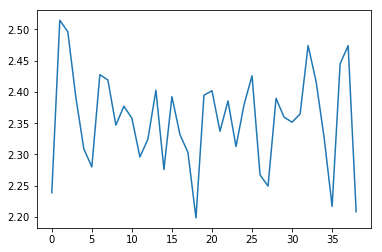

[ 0.09082535  0.17446782  0.16507269  0.00792867 -0.06083119 -0.16273234
  0.03887882 -0.10283275 -0.17272954  0.02195246]
2.806044517503409


In [85]:
plt.plot(losses)
plt.show()
print(bias)
diff_thetas = thetas - init_thetas
print(np.sqrt(np.sum(diff_thetas*diff_thetas)))

In [86]:
#Check for favoritism
for i in range(NUM_CLASSES):
    print(circuit_tighten(np.random.randn(ENCODING_SIZE), MASK, thetas[i]) + bias[i])

[ 0.72482535  0.12482535 -0.15117465  0.72682535]
[-0.62953218 -0.38753218 -0.29553218 -0.54553218]
[0.60307269 0.28107269 0.07107269 0.60707269]
[ 0.23992867  0.39192867 -0.90007133  0.07192867]
[-0.25083119  0.52916881  0.57316881 -0.24883119]
[-0.26873234  0.23926766 -0.49873234 -0.32273234]
[-0.61912118  0.19887882  0.65087882 -0.19912118]
[ 0.80316725  0.38516725 -0.73483275  0.82916725]
[ 0.29127046 -0.37272954 -0.29072954  0.34527046]
[-0.38604754  0.41395246  0.12195246  0.13995246]


In [46]:
#Overfit a linear model with same number of parameters:
etas = [1e-2]
start = time.time()
recoder = nn.Sequential(nn.Linear(10, 40), nn.ReLU(), nn.Linear(40, 10))
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(recoder.parameters(), lr=.01)
losses = []
for eta in etas:
    for epoch in range(30):
        running_loss = 0.0
        for i, data in overfit:
            inputs, labels = data
            optimizer.zero_grad()
            X = encoder(inputs.view(len(labels), -1))
            outputs = recoder(X)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            if i % 8 == 7:
                print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 8))
                running_loss = 0.0
        print(running_loss)
        losses.append(running_loss)

for i, data in overfit:
    inputs, labels = data
    X = encoder(inputs.view(len(labels), -1))
    outputs = recoder(X)
    print(labels)
    guesses = np.argmax(outputs.detach().numpy(), axis=1)
    counter = 0
    for i in range(len(guesses)):
        if labels[i] == guesses[i]:
            counter += 1
    print(counter/16)

6.7199883460998535
4.027747631072998
5.111584186553955
3.021775245666504
2.4269092082977295
2.7653069496154785
3.069201707839966
2.2457666397094727
1.9271575212478638
1.7374266386032104
1.5183058977127075
1.694549798965454
1.6607728004455566
1.2809019088745117
1.3200790882110596
1.4291044473648071
1.4116361141204834
1.135733723640442
1.1620030403137207
1.2151148319244385
1.2104133367538452
1.048457145690918
1.0661566257476807
1.046869158744812
1.0536484718322754
0.9611916542053223
0.971992552280426
0.9176661372184753
0.9294551610946655
0.8672801852226257
tensor([9, 0, 4, 5, 9, 3, 6, 1, 9, 5, 4, 1, 4, 8, 8, 9])
0.625


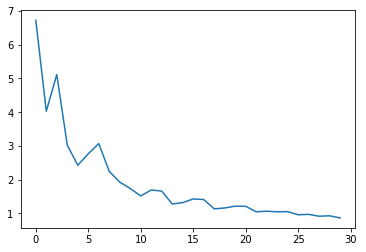

In [47]:
plt.plot(losses)
plt.show()